In [1]:
import json
import requests
import numpy as np
import datetime
from datetime import timedelta, date
import matplotlib.pyplot as plt

In [2]:
database_path = "/Users/tnk12/Documents/CapitalOne_Hackaton/Data/au_hackathon_final_10_27_1.json"
# with open(database_path,'r') as f:
#     json_string = f.read()
# data_json = json.loads(json_string)

In [3]:
# max_number_of_customers = 0
# for account in data_json:
#     customer_list = account["customer"]
#     nb_costumer = len(customer_list)
#     if max_number_of_customers < nb_costumer:
#         max_number_of_customers = nb_costumer
#         print("Account_id : {}, nb_of_costumer = {}".format(account['account_id'],nb_costumer))

## Compute Counts Per Age Category:
* 12 - 21 : teenager
* above 22 : grown-up

In [4]:
# def calculate_age(dob_string, today):
#     """Compute the difference between today date and the date of birth
#     :param1 dob_string: datetime object
#     :param2 today: datetime object
#     """
#     born = datetime.datetime.strptime(dob_string,'%m/%d/%Y')
#     return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
# today = datetime.date.today()
# data = "/Users/tnk12/Documents/CapitalOne_Hackaton/Data/au_hackathon_final_10_27_1.json"
# with open(data,'r') as f:
#     json_string = f.read()
# data_json = json.loads(json_string)
# age_category = np.array([12, 21, 200])
# account_ages_caterogy = np.zeros((len(data_json), age_category.size-1),dtype=np.uint16)
# for i, account in enumerate(data_json):
#     account_age_list = []
#     account_age_list = [calculate_age(customer['dob'], today) for customer in account['customer']]
#     min_age = min(account_age_list)
#     account_age_list_to_category = np.digitize(account_age_list, age_category)
#     uniques, counts = np.unique(account_age_list_to_category, return_counts=True)
#     account_ages_caterogy[i,uniques-1] = counts

# print("Category average count : {}".format(account_ages_caterogy.mean(0)))

### Statistics Class

In [5]:
class CustomersStats:
    """This class implements overall statistics about customers
    """
    def __init__(self, path_to_json_file, data_mode="json", json_dict=None, 
                 customer_daily_spendings=None, customer_daily_rewards=None,
                 customer_monthly_spendings=None, customer_monthly_rewards=None
                ):
        self.today = datetime.date.today()
        self.data_mode = data_mode
        if data_mode == "json":
            self.data_path = path_to_json_file
            # temporary memoisation
            if json_dict is not None:
                self.json_dict = json_dict
            else:
                self.json_dict = self.load_json(path_to_json_file)
            # Hard coded date range from the fake data
            self.data_day_range = [date(2016, 11, 1), date(2017, 10, 29)]
            self.date_range_map, self.date_string_list, self.date_list = self.create_all_day_map(*self.data_day_range)
            self.month_list = self.month_list(*self.data_day_range)
            self.month_idx_intervals = self.compute_month_idx_intervals()
            self.nb_days = len(self.date_range_map)
            self.customer_map = {ID:i for i, ID in enumerate(customer['customer_id'] for account in self.json_dict for customer in account['customer'])}
            self.nb_customers = len(self.customer_map)
            
        elif data_mode == "api":
            endpoint_list = ["/accounts", "/customers", "/transactions"]
            url = "https://3hkaob4gkc.execute-api.us-east-1.amazonaws.com/prod/au-hackathon"
            urls = [url + endpoint for endpoint in endpoint_list]
            self.url_accounts, self.url_customers, self.url_transactions = urls
    
        # bunch of temporary memoization loadings
        if customer_daily_spendings is not None:
            self.customer_daily_spendings = customer_daily_spendings
        else:
            self.customer_daily_spendings = None
            
        if customer_daily_spendings is not None:
            self.customer_daily_rewards = customer_daily_rewards
        else:
            self.customer_daily_rewards = None
            
        if customer_monthly_spendings is not None:
            self.customer_monthly_spendings = customer_monthly_spendings
        else:
            self.customer_monthly_spendings = None
            
        if customer_monthly_rewards is not None:
            self.customer_monthly_rewards = customer_monthly_rewards
        else:
            self.customer_monthly_rewards = None
        
    def load_json(self, path_to_json_file):
        with open(path_to_json_file,'r') as f:
            json_string = f.read()
        return json.loads(json_string)
        
    def daterange(self, start_date, end_date):
        """Return a generator that iterate between two dates (datetime objects)
        """
        for n in range(int((end_date - start_date).days)):
            yield start_date + timedelta(n)
                
    def create_all_day_map(self, start_date, end_date):
        """Returns:
        - a dictionnary that map a date "YYYY-Month_in_Letters-dd" to its index in the list of all days
        - the list of all the date as strings
        """
        day_to_index_map = {}
        date_list = []
        date_string_list = []
        for i, single_date in enumerate(self.daterange(start_date, end_date)):
            date_string = single_date.strftime("%Y-%B-%d").replace("-0","-")
            day_to_index_map[date_string] = i
            date_list.append(single_date)
            date_string_list.append(date_string)
        return day_to_index_map, date_string_list, date_list
    
    def month_list(self, start_date, end_date):
        """Return a list of tuple (year, month) between start_date and end_date
        """
        month_range, month_set = list(), set()
        for n in range((end_date - start_date).days):
            d = (start_date + timedelta(n))
            t = (d.year, d.month)
            if t not in month_set:
                month_set.add(t)
                month_range.append(t)
        return month_range
    
    def compute_month_idx_intervals(self):
        month_idx_interval_list = []
        start_idx_current_month = 0
        current_month = self.date_list[0].month
        for i, d in enumerate(self.date_list):
            month = d.month
            if month != current_month:
                current_month = month
                # We should append [start_idx_current_month,i-1] but we add 1 to make the next slice call direct
                # So [start_idx_current_month,i-1+1] = [start_idx_current_month,i]
                month_idx_interval_list.append([start_idx_current_month,i])
                start_idx_current_month = i
        month_idx_interval_list.append([start_idx_current_month,i])
        return month_idx_interval_list

    def compute_customer_daily_matrix(self, return_matrices = False):
        """compute two global matrices containing the daily information about transactions and rewards
        for each customers
        matrix.shape = (total_number_of_customers, total_number_of_days_in_the_data)
        """
        # Matrix calculation
        all_days_spendings = np.zeros((self.nb_customers, self.nb_days),dtype=np.float)
        all_days_rewards = np.zeros((self.nb_customers, self.nb_days),dtype=np.float)
        customer_idx = 0
        for account in self.json_dict:
            for customer in account['customer']:
                for transaction in customer['transactions']:
                    date_string = '{}-{}-{}'.format(transaction['year'],transaction['month'],transaction['day'])
                    date_index = self.date_range_map[date_string]
                    all_days_spendings[customer_idx,date_index] += transaction['amount']
                    all_days_rewards[customer_idx,date_index] += transaction['rewards_earned']
                customer_idx += 1
                
        self.customer_daily_spendings = all_days_spendings
        self.customer_daily_rewards = all_days_rewards
        
        if return_matrices: 
            return all_days_spendings, all_days_rewards

    def compute_customer_monthly_matrix(self, return_matrices = False):
        """compute from the daily matrices the monthly values (spendings, rewards) for each customers
        matrix.shape = (total_number_of_customers, total_number_of_month)
        """
        if self.customer_daily_spendings is None or self.customer_daily_rewards is None:
            self.customer_daily_spendings, self.customer_daily_rewards = self.compute_customer_daily_matrix()
        
        nb_months = len(self.month_idx_intervals)
        # Matrix calculation
        all_months_spendings = np.zeros((self.nb_customers, nb_months), dtype=np.float)
        all_months_rewards = np.zeros((self.nb_customers, nb_months), dtype=np.float)
        for i, month_interval in enumerate(self.month_idx_intervals):
            start_idx, end_idx = month_interval
            all_months_spendings[:, i] = self.customer_daily_spendings[:,start_idx:end_idx].sum(1)
            all_months_rewards[:, i] = self.customer_daily_rewards[:,start_idx:end_idx].sum(1)
        
        self.customer_monthly_spendings = all_months_spendings
        self.customer_monthly_rewards = all_months_rewards
        
        if return_matrices: return all_months_spendings, all_months_rewards
    
    def display_stats(self):
        assert (self.customer_daily_spendings is not None), "Statistical matrix for spendings has not been computed yet"
        assert (self.customer_daily_rewards is not None), "Statistical matrix for rewards has not been computed yet"
        
        x = np.arange(self.nb_days)
        
        spending_med = np.median(self.customer_daily_spendings,axis=0)
        spending_avg = self.customer_daily_spendings.mean(0)
        reward_med = np.median(self.customer_daily_rewards,axis=0)
        reward_avg = self.customer_daily_rewards.mean(0)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,5), sharex=True)
        ax1.scatter(x, spending_med,s=2,color='b')
        ax1.set_title('Daily Median spending in one year')
        ax1.axis([0, 370, 0, 25])
        ax2.scatter(x, spending_avg,s=2,color='b')
        ax2.set_title('Daily Average spending in one year')
        ax2.axis([0, 370, 0, 200])
        ax3.scatter(x, reward_med,s=2,color='b')
        ax3.set_title('Daily Median rewards in one year')
        ax4.scatter(x, reward_avg,s=2,color='b')
        ax4.set_title('Daily Average rewards in one year')
        ax4.axis([0, 370, 0, 3])
        plt.show()
    
    def get_daily_values(self, value_type, customer_id = None, interval = None, expand_days = False):
        """Get the array (or matrix) of spendings/rewards, with optionnal filters
        :param value_type: specify the query type {spending, reward}
        :param customer_id: if an int is provided, returns only the information for the customer
                      if a list of int is provided, returns only the information for each specific customers
        :param interval: a tuple of strings (start_date, end_date) to define a time range
        :expand_days: returns the total array with null values for days without activity
        """
        if self.data_mode == "json":
            
            if value_type == "spending":
                value_matrix = self.customer_daily_spendings
            elif value_type == "reward":
                value_matrix = self.customer_daily_rewards
                
            if customer_id: 
                if isinstance(customer_id, int):
                    customer_rows = [self.customer_map[customer_id]]
                elif isinstance(customer_id, list):
                    customer_rows = [self.customer_map[ID] for ID in customer_id] 
                value_matrix = value_matrix[customer_rows]

            if interval:
                interval_formatted = [x.replace("-0","-") for x in interval]
                start_column_idx, end_column_idx = [self.date_range_map[x] for x in interval_formatted]
                value_matrix = value_matrix[:, start_column_idx:end_column_idx]
                
            if not expand_days:
                if value_matrix.shape[0] == 1:
                    mask_null = np.equal(value_matrix, 0)
                    return value_matrix[~mask_null]
                else:
                    print("Can't remove null values on a 2-dimensionnal array. Returning full array")
   
            return value_matrix

#         elif self.data_mode == "api":
            
    
    def get_daily_spendings_by_customer_id(self, customer_id, interval=None, expand_days=False):
        """
        :param customer_id: int
        :param interval: (start_date, end_date) as a tuple("yyyy-Month-dd","yyyy-Month-dd")
        """
        return self.get_daily_values("spending", customer_id=customer_id, interval=interval, expand_days=expand_days)

    def get_daily_rewards_by_customer_id(self, customer_id, interval=None, expand_days=False):
        return self.get_daily_values("reward", customer_id=customer_id, interval=interval, expand_days=expand_days)
    
    def get_daily_spending_all_customers(self, interval=None):
        return self.get_daily_values("spending", interval=interval, expand_days=True)

    def get_daily_rewards_all_customers(self, interval=None):
        return self.get_daily_values("reward", interval=interval, expand_days=True)
    

    def compute_customer_summary(self):
        """Compute the json customer database summary, with the following format :
        {
         “account_id”: 12323412,
         “customer_id”: 90987987,
         “summaries”: [{
             “budget”: 100,
             “month”: 12,
             “payment”: 10,
             “reward_rank”: 3,
             “rewards”: 2,
             “saving_rank”: 1,
             “savings”: 0,
             “spending”: 20,
             “year”: 2017
           }]
        }
        """
        monthly_budgets = np.median(self.customer_monthly_spendings, axis = 0)
        summary = list()
        for account in self.json_dict:
            account_customer_dict_list = []
            customers_id = [customer['customer_id'] for customer in account['customer']]
            customer_rows = [self.customer_map[ID] for ID in customers_id]
            is_primary_list = [_['is_primary'] for _ in account['customer']]
            payments = [_['total_balance_paid'] for _ in account['payments']]
            # We get the monthly spendings of the family
            account_monthly_spendings = self.customer_monthly_spendings[customer_rows,:]
            # We get the monthly rewards of the family
            account_monthly_rewards = self.customer_monthly_rewards[customer_rows,:]
            # We compute the monthly savings of the family
            diff = monthly_budgets - account_monthly_spendings
            account_monthly_savings = np.cumsum(diff, axis=1)
            # We compute the saving/reward ranking
            account_monthly_savings_ranks = np.argsort(account_monthly_savings,axis=0)[::-1] + 1
            account_monthly_rewards_ranks = np.argsort(account_monthly_rewards,axis=0)[::-1] + 1
            
            # For each customer
            for customer_id,\
                is_primary,\
                customer_monthly_spendings,\
                customer_monthly_rewards,\
                customer_monthly_rewards_ranks,\
                customer_monthly_savings,\
                customer_monthly_savings_ranks\
                in zip(customers_id,is_primary_list,
                       account_monthly_spendings,
                       account_monthly_rewards,
                       account_monthly_rewards_ranks,
                       account_monthly_savings, 
                       account_monthly_savings_ranks):
                
                customer_month_summary_list = []
                
                # For each month
                for (year, month),\
                    payment, \
                    customer_month_spendings,\
                    customer_month_rewards,\
                    customer_month_rewards_rank,\
                    customer_month_savings,\
                    customer_month_savings_rank,\
                    customer_month_budget\
                    in zip(self.month_list,
                        payments,
                        customer_monthly_spendings,
                        customer_monthly_rewards,
                        customer_monthly_rewards_ranks,
                        customer_monthly_savings,
                        customer_monthly_savings_ranks,
                        monthly_budgets):
                        
                    customer_month_summary_dict = {"budget":int(customer_month_budget),
                                                   "month":month,
                                                   "year":year,
                                                   "rewards":int(customer_month_rewards),
                                                   "reward_rank":int(customer_month_rewards_rank),
                                                   "savings":int(customer_month_savings),
                                                   "saving_rank":int(customer_month_savings_rank),
                                                   "spending":int(customer_month_spendings),
                                                   "payment":0}
                    if is_primary:
                        customer_month_summary_dict["payment"] = payment
                    
                    customer_month_summary_list.append(customer_month_summary_dict)
                customer_dict = {'account_id':account['account_id'],
                                 'customer_id':customer_id, 
                                 'summaries':customer_month_summary_list}
                account_customer_dict_list.append(customer_dict)
            summary.extend(account_customer_dict_list)
        return summary

In [6]:
# Memoized version of the instanciation
# Stats = CustomersStats(data, json_dict=data_json,
#                    customer_daily_spendings=cds, customer_daily_rewards=cdr,
#                    customer_monthly_spendings=cms, customer_monthly_rewards=cmr)
# Stats.display_stats()

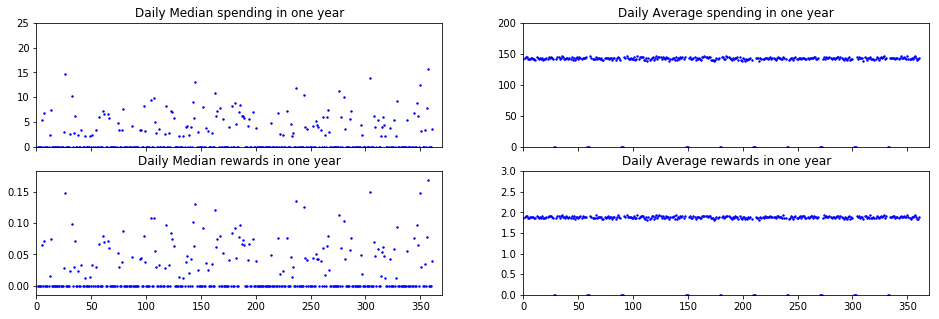

In [7]:
Stats = CustomersStats(database_path)
cds, cdr = Stats.compute_customer_daily_matrix(return_matrices=True)
cms, cmr = Stats.compute_customer_monthly_matrix(return_matrices=True)
Stats.display_stats()

In [8]:
Database_summary = Stats.compute_customer_summary()

In [9]:
# with open("/Users/tnk12/Documents/CapitalOne_Hackaton/Data/Database_summary.json", 'w') as output_file:
#     json.dump(Database_summary,output_file)

In [11]:
print("Number of items in the Database summary = {}".format(len(Database_summary)))

Number of items in the Database summary = 12445


In [ ]:
# print(Stats.get_daily_spendings_by_customer_id(100730000,expand_days = False))

In [ ]:
# print(Stats.get_daily_spendings_by_customer_id(100530000, interval=("2016-December-2", "2016-December-15"), expand_days=True))

In [ ]:
# print(Stats.get_daily_rewards_by_customer_id(100530000, interval=("2016-December-2", "2016-December-26")).sum())

In [ ]:
# print(Stats.get_daily_spending_all_customers(interval=("2016-December-2", "2016-December-06")).shape)

In [ ]:
# print(Stats.get_daily_rewards_all_customers(interval=("2016-December-2", "2016-December-06")).sum(1))

In [ ]:
# print(Stats.get_daily_spendings_by_customer_id(100730000, interval=("2016-November-10", "2016-December-10")).sum())